<a href="https://colab.research.google.com/github/Miyazaki-Kohei/DataScience/blob/main/colab_notebooks/large_language_mario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large Language Mario

LLMを使ってマリオをプレイするチャレンジ

## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [1]:
!pip install -qqq gym-super-mario-bros==7.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.6 MB/s eta 0:00:00


その他、必要なライブラリをインストールします。

In [2]:
!apt -qq update
!apt install -y -qq xvfb
!pip install -qqq pyvirtualdisplay

59 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 59 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...


必要なライブラリをインポートします。

In [3]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
import requests

import os
from google.colab import userdata
import base64
import json

## AIマリオ環境の構築

AIマリオの環境構築を行います。



### AIマリオ環境初期化と動作確認
環境の確認です。

In [4]:
STAGE_NAME = 'SuperMarioBros-1-1-v0'

In [5]:
# マリオ1-1の環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定します。
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# MOVEMENT = [["right"], ["right", "A"]]
# env = JoypadSpace(env, MOVEMENT)
# env = JoypadSpace(env, COMPLEX_MOVEMENT)
# env = JoypadSpace(env, RIGHT_ONLY)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


ステージの初期化と行動空間の設定をしています。

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されています。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

自分で自由に設定する他、`gym_super_mario_bros`では`SIMPLE_MOVEMENT`, `COMPLEX_MOVEMENT`といった複数のパターンが登録されています。どのようなパターンがあるかは、[gym_super_mario_brosのソースコード](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py)を読むか、以下のように中身を`print`して確認する方法があります。

L今回は`SIMPLE_MOVEMENT`を採用しています。

In [6]:
print(SIMPLE_MOVEMENT)
print(COMPLEX_MOVEMENT)

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [7]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0.0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


行動`action`の範囲や状態`state`の範囲を確認したい場合は、以下を実行してください。

```python
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

print('action space------------------')
print_spaces(env.action_space)
print('observation space------------------')
print_spaces(env.observation_space)
```

最後に`state`を画像として可視化してみます。

マリオのプレイ画面であることを確認できます。

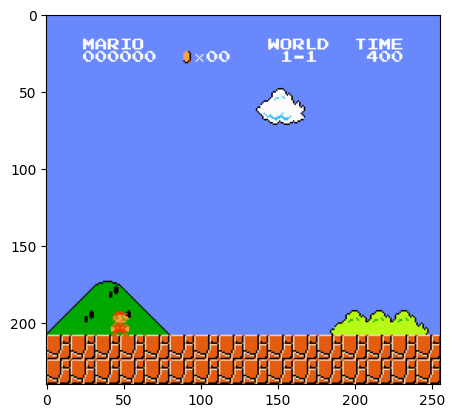

In [8]:
plt.imshow(state)

`state`は`numpy.ndarray'です。

In [9]:
print(type(state))

<class 'numpy.ndarray'>


`state`を画像に変換します。

In [10]:
image = Image.fromarray(state)
image.save('state.png')

画像も表示を確認します

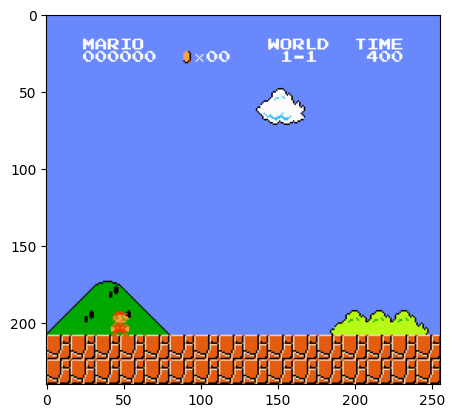

In [11]:
img = Image.open('state.png')
imshow(img)

## LLMのテスト

LLMが正しく画像を読み込んでプレイできるかテストします。
OpenAIのライブラリをインストールします。

In [12]:
!pip install -qqq openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00


OpenAI API KEYを読み込みます。

あらかじめ、Google Colabのシークレットキーとして`OPENAI_API_KEY`を設定しておいてください。シークレットキーの設定方法は以下記事など参考にしてください。


[Google Colab のシークレット機能の使い方](https://note.com/npaka/n/n79bb63e17685)

LLMで画像を読み込めるようにエンコードする関数を定義します。

In [13]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

画像からマリオの動きを推論する関数を定義します。

In [14]:
def predict(state):
    # 今のマリオの状態をPNG画像として保存
    image = Image.fromarray(state)
    image.save('state.png')

    # 画像ファイルをエンコーディング
    image_path = "./state.png"
    base64_image = encode_image(image_path)

    api_key = userdata.get("OPENAI_API_KEY")

    # プロンプト
    prompt = """
        この画像はゲーム、スーパーマリオのプレイ画面です。
    　　 画面に応じて、以下の7つのボタン操作ができます。ボタン操作は以下の7つからどれかを選んでください
    　　 NOOPが操作しない。Aがジャンプ。Bがダッシュです。

        0 = 'NOOP'
        1 = 'right'
        2 = 'right', 'A'
        3 = 'right', 'B'
        4 = 'right', 'A', 'B'
        5 = 'A'
        6 = 'left'

        以下の通りjson出力してください。日本語でお願いします。

    　　 explanation: 画面の説明
        reason: ボタン操作の理由
        action: ボタン操作の種類
    """

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }

    payload = {
    "model": "gpt-4o-2024-08-06",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": f"{prompt}"
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
            }
        ]
        }
    ],
    "max_tokens": 300,
    "temperature": 1,
    "response_format": {
        "type": "json_schema",
        "json_schema": {
        "name": "mario_action",
        "schema": {
            "type": "object",
            "properties": {
            "explanation": {
                "type": "string",
            },
            "reason": {
                "type": "string",
            },
            "action": {
                "type": "integer"
            }
            },
            "required": ["explanation", "reason", "action"],
        }
        }
    }
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    content_dict = json.loads(response.json().get('choices')[0].get('message').get('content'))

    action = content_dict.get('action')
    explanation = content_dict.get('explanation')
    reason = content_dict.get('reason')

    if action == None:
        action = 0


    return action, explanation, reason

推論する関数をテストします。

In [15]:
action, explanation, reason = predict(state)

アクションを確認します。右に進む（`1`）かダッシュして右に進む（`2`）になっていることを確認します。

In [16]:
action

1

マリオの状況判断（画像の説明）を確認します

In [17]:
explanation

'マリオがステージ1-1のスタート地点にいる。障害物や敵はまだ見えない。'

行動の理由を確認します

In [18]:
reason

'ゲームの初期状態であり、進行方向は右なので前に進むのが良い。'

## AIマリオのテスト

AIモデルをテストします。

テスト回数等を設定します。

In [19]:
EPISODE_NUMBERS = 1
MAX_TIMESTEP_TEST = 1000
SKIP_RATE = 10

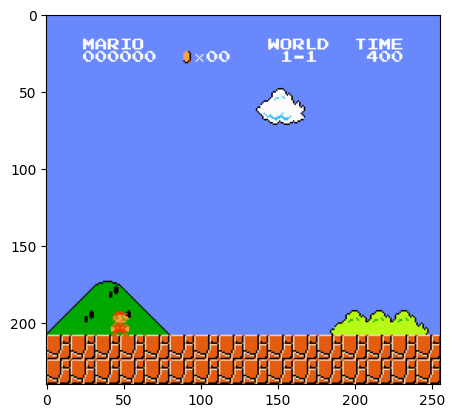

action: 1
explanation: スーパーマリオのステージ1-1の開始地点の画面です。
reason: ゲーム開始時は特に障害物がないため、まずは右に進むと良いです。


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


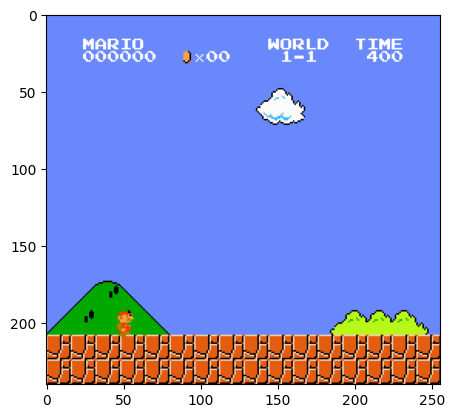

action: 1
explanation: マリオがスタート地点にいます。特に敵や障害物は見当たりません。
reason: ゲームの冒頭なので、まずは右に進んでみましょう。


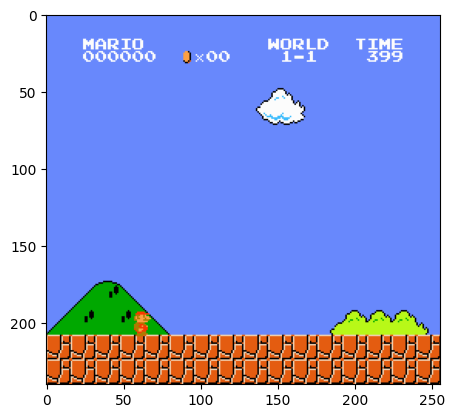

action: 1
explanation: マリオがスタート地点にいる通常の平地ステージの画面。
reason: 前に進むためには、右に移動する必要がある。


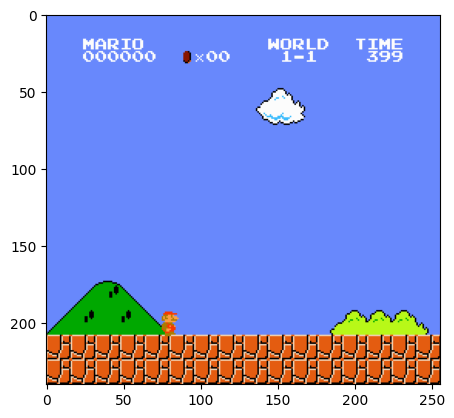

action: 1
explanation: マリオはゲームの開始位置におり、障害物は目の前にない。また、右側には道が続いている。
reason: ゲームを進行するためには、マリオを右方向へ移動させる必要がある。特に障害物もないため、単に右に進む。


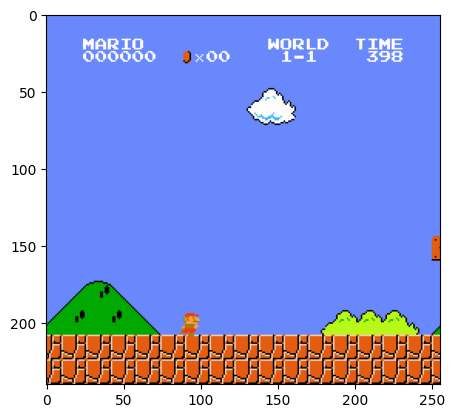

action: 1
explanation: これはスーパーマリオの最初のステージである1-1のスクリーンです。マリオはスタート地点に立っており、右側に進むことが必要です。特に障害物や敵キャラクターは見当たらないため、通常の右方向への移動が適切です。
reason: ゲームの初期位置にいるため、右方向へ進むことでステージを進める必要があります。現在は特にジャンプやダッシュを必要とする状況は見受けられないので、通常の移動が適しています。


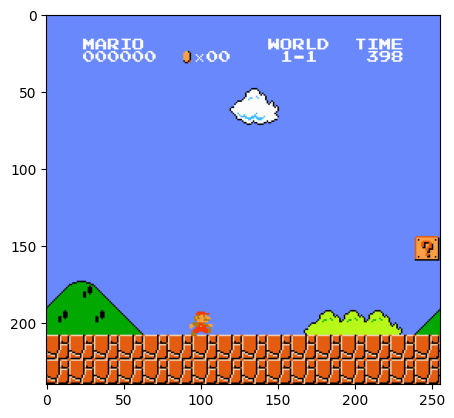

action: 1
explanation: マリオは最初の1-1のステージに立っています。右側にブロックが見えます。
reason: 最初のステージなので、まずは右に進んでブロックを調べるべきです。


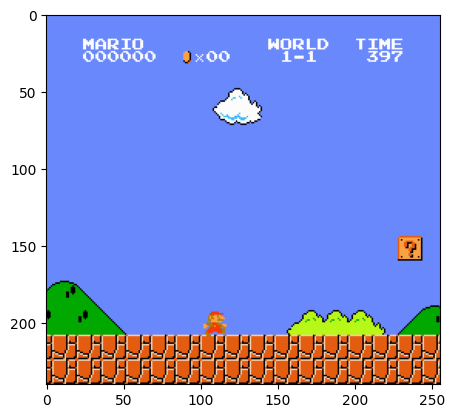

action: 2
explanation: プレイヤーはスタート地点付近におり、前方にブロックがあります。
reason: 前進しブロックにジャンプしてヒットさせて中身を確認するためです。


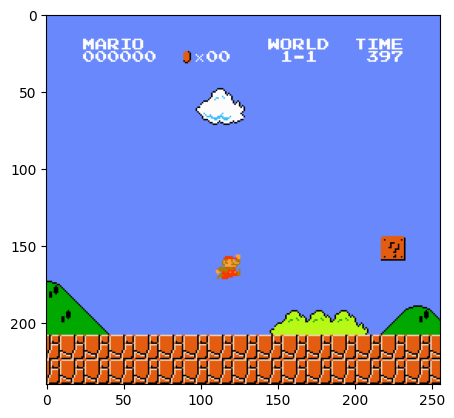

action: 4
explanation: マリオが空中にいて、右側にブロックがあります。
reason: マリオは空中にあり、ブロックに向かってジャンプしていますが、ダッシュをしてブロックにタイミングよく到達したいです。


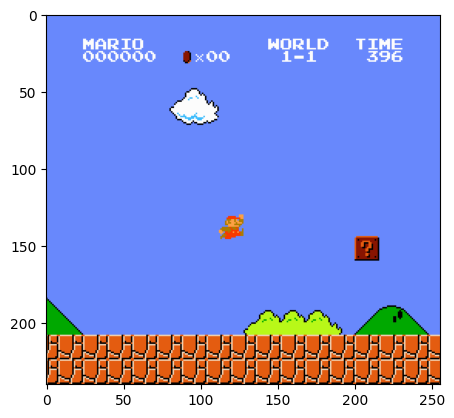

action: 2
explanation: マリオが空中にいて、ブロックの右上にいる。
reason: ジャンプしてブロックに当たるために前方への移動が必要。


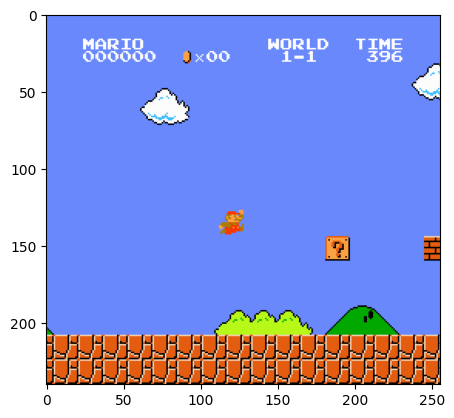

action: 4
explanation: マリオがジャンプ中で、目の前にアイテムブロックがあります。
reason: ジャンプ中であるため、前進しながら落下後にアイテムを獲得できるようにする。


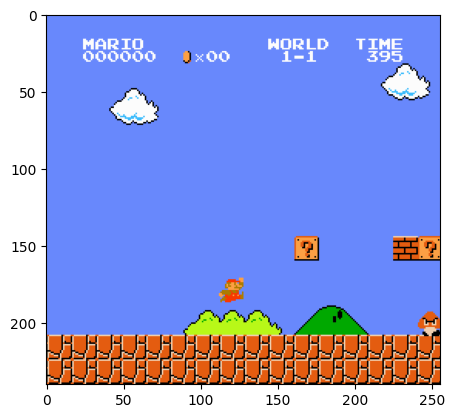

action: 3
explanation: マリオがジャンプしており、次に進むべき方向は右側。敵が見えないので、次のアクションを考慮。
reason: ジャンプ中で前進するため、右方向への移動を維持しつつ、スピードアップしてスムーズに進むべき。


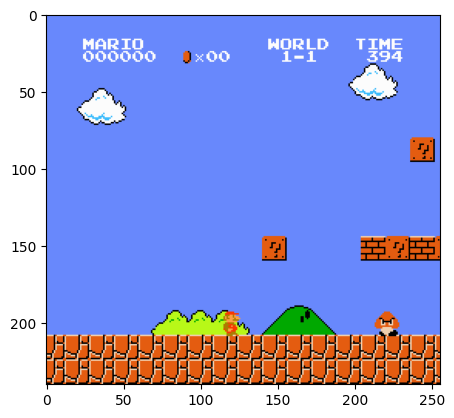

action: 2
explanation: 画面にはマリオが左側に立っており、右側には通常の道とクリボーがいます。このまま進むとクリボーにぶつかってしまいます。
reason: クリボーを避けるためにジャンプしながら右に進む必要があります。


/usr/local/lib/python3.10/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


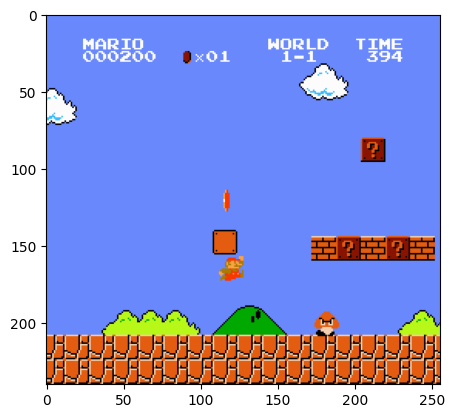

action: 2
explanation: マリオがコインブロックを叩いてコインを取得しています。画面右側にクリボーが接近中です。
reason: クリボーを避けつつ前進するために『右』と『ジャンプ』を同時に押す必要があります。


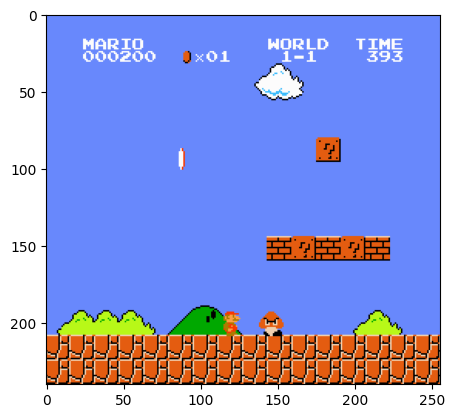

action: 5
explanation: マリオが敵のクリボーに近づいている場面です。
reason: クリボーに当たらないようにジャンプで飛び越える必要があります。
test episode: 0 reward: 238.0 time: 150
average reward: 238.0 average time: 150.0 best_reward: 238.0


In [20]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0.0
    total_time[i] = 0
    skip_numb = SKIP_RATE
    frames = []

    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        if skip_numb < SKIP_RATE:
            skip_numb += 1
        else:
            skip_numb = 0
            action, explanation, reason = predict(state)

            plt.imshow(state)
            plt.pause(0.001)

            print(f'action: {action}')
            print(f'explanation: {explanation}')
            print(f'reason: {reason}')

        state, reward, done, info = env.step(action)
        total_reward[i] += reward
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

`<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>`という表示ができたらクリアできています。

クリアできない場合は、複数回プレイして一番良いプレイ動画が保存されます。

実行のたびに結果は変わります。何回か試してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [21]:
SKIP_RATE = 4

画像を間引く処理をします。

In [ ]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

In [ ]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。

In [ ]:
ani.save('ai_mario.mp4')

動画ファイルをダウンロードします。

In [ ]:
from google.colab import files
files.download('ai_mario.mp4')

GIFアニメ形式で保存します。

In [ ]:
import imageio
imageio.mimsave('ai_mario.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=15)

GIFアニメをダウンロードします。

In [ ]:
from google.colab import files
files.download('ai_mario.gif')

## リファレンス

- https://platform.openai.com/docs/guides/vision
- https://platform.openai.com/docs/guides/structured-outputs/introduction
- https://openai.com/index/introducing-structured-outputs-in-the-api/
- https://qiita.com/DEmodoriGatsuO/items/4c4734b78973970e0d3d
- https://platform.openai.com/settings/organization/billing/overview